# A History Generator

In this notebook, we combine a simple model of state formation and fracture with a Tracery grammar to generate, and visualize, the turbid history of a region. Based on [this question](source: https://gamedev.stackexchange.com/questions/23659/is-there-a-way-to-procedurally-generate-the-history-of-a-world
).

In [1]:
import sys
import random
import tracery 
from tracery.modifiers import base_english
from pprint import pprint

Now we set a number of rules for the kind of language to be used to describe the results of our model. Note that some rules (like 'violent') call other rules.

In [2]:
rules = {
    'time': ['a few years later', 'as it came to pass','within a generation'],
    'connector': ['But','Then','Years passed - ','And then','The seasons cycled - but'],
    'dissolved': ['dissolved', 'slowly fell', 'quickly shattered', 'collapsed'],
    'strength': ['fragile', 'weakening', 'uncertain', 'weak'],
    'island': ['island.','peninsula, shielded from the rest of the world by tall mountains.','continent that should have been large enough for us all.','archipelago of islands and islets in an azure sea.'],
    'climatedisaster': ['flooding ruined the crops; the famine','the clouds grew dark, and hunger stalked the land. Sickness','pestilence and plague killed thousands, and'],
    'problem': ['hunger','patience','good will','strength'],
    'ruler': ['King','Patrician','Satrap','Consul','Princess','Queen','President','Dictator','Elders','Council'],
    'beginning': 'These people shared a single #island#',
    'originpartition': '#connector# #partition# and so,',
    'originconfederation': '#connector# #confed# and so, ',
    'originrevolution': ['#violent#','#peaceful#'],
    'originconquest': ['The thirst for new lands, new glory, and the desire to distract the people, led to new conquests','Sometimes, a people covet the wealth of their neighbours. And so','For honour, or for shame, I know not which - but the #ruler# sent the warriors to work. Thus'],
    'violent': ['#time#, the #problem# of the people could bear it no longer, and they rose up in violent revolution','Mistakes, blunders, and craven foolishness combined, and the whole edifice collapsed.','Whispers and rumors did the work of assassins, and the #ruler# could not control the people.'],
    'peaceful': ['#time#, the #ruler# gave up power and fled into exile'],
    'partition': ['#time#, class struggle tore the #strength# consensus apart','low cunning and high treachery divided them','#climatedisaster# weakened them all'],
    'confed': ['with a common enemy in view, they joined in alliance','#climatedisaster# weakened them all']
}

grammar = tracery.Grammar(rules)
grammar.add_modifiers(base_english)

We have a file with a list of place names. These too could be generated using something like Tracery if we wanted. 

We also set some of the parameters for the visualization, which we will accomplish using graphviz.

In [3]:
# Names is a newline separated list of nation names.
file = "names.txt"
names = open(file, "r").read().split("\n") 
history = []
dot = False
if len(sys.argv) > 1 and sys.argv[1] == "--dot":
  dot = True


This codeblock contains the core of our model, which uses a simple diceroll mechanic.

In [4]:
def wrap(str, wrap='"'):
  return wrap+str+wrap

def merge(states, names):
  number = random.randint(2,3)
  mergers = [] 
  if number < len(states):
    mergers = random.sample(states, number)
    new_name = random.choice(names)
    states = list(set(states).difference(set(mergers)))
    states.append(new_name)
    names.remove(new_name)
    if dot:
      for state in mergers:
        print '"%s" -> "%s" [label="confederation "]'%(state, new_name)
      print '{rank=same; %s }'%wrap(new_name)
    else:
      print grammar.flatten("#originconfederation#")
      print " %s became '%s'"%( " and ".join(map(wrap,mergers)), new_name)
  return states, names 


def split(states, names):
  number = random.randint(2,3)
  if number < len(names):
    splitter = random.choice(states)
    states.remove(splitter)
    new_states = random.sample(names, number)
    names = list(set(names).difference(set(new_states)))
    states = list(set(states).union(set(new_states)))
    if dot:
      for state in new_states:
        print '"%s" -> "%s" [label="partition "]'%(splitter, state)
      print '{rank=same; %s }'%("; ".join(map(wrap, new_states)))
    else:
      print grammar.flatten("#originpartition#")
      print " '%s' dissolved in fragments, eventually becoming %s"%(splitter, " and ".join(map(wrap,new_states)))
  return states, names

def revolt(states, names):
  old = random.choice(states)
  new = random.choice(names)
  names.remove(new)
  states.remove(old)
  states.append(new)
  if dot:
    print '"%s" -> "%s" [label="revolution "]'%(old, new)
    print '{rank=same; "%s"}'%new
  else:
    print grammar.flatten("#originrevolution#")
    print "The old '%s' was no more; a new dawn broke on '%s'"%(old, new)
  return states, names

def conquest(states, names):
  if len(states) > 1:
    loser = random.choice(states)
    states.remove(loser)
    winner = random.choice(states)
    if dot:
      print '"%s" -> "%s" [label="conquered by"]'%(loser, winner)
    else:
      print grammar.flatten("#originconquest#")
      print " '%s' conquered '%s'"%(winner, loser)
  return states, names

Now we get ready to generate the history. In the code below, anything with 'dot' is an instruction for graphviz.

In [5]:
#ignore empty names
names = [name for name in names if name] #yes, really.

origin = random.sample(names, random.randint(1,3))
names = list(set(names).difference(set(origin)))
history.append(origin) #random starting states

In [6]:
if dot:
  print "digraph g {"
  print "{rank=same; %s}"%("; ".join(map(wrap,origin)))
else:
  print("Gather by, young ones, and let me tell you of our nations and peoples. \n In the beginning there was %s"%(" and ".join(map(wrap,history[0]))))
  print grammar.flatten("#beginning#")

Gather by, young ones, and let me tell you of our nations and peoples. 
 In the beginning there was "Heawoth"
These people shared a single island.


In [7]:
while names:
  func = random.choice([merge, split, revolt, conquest, merge, split, revolt, revolt, conquest])
  states, names = func(history[-1], names)
  history.append(states)

if dot:
  print '{rank=same; %s}'%("; ".join(map(wrap,history[-1])))
  print "}"
else:
  print "Standing proud upon the ruins there are only now %s"%("and ".join(map(wrap,history[-1])))


as it came to pass, the Patrician gave up power and fled into exile
The old 'Heawoth' was no more; a new dawn broke on 'Duchy of Corica'
Then pestilence and plague killed thousands, and weakened them all and so,
 'Duchy of Corica' dissolved in fragments, eventually becoming "Voches" and "Kingdom of Amoth"
Years passed -  low cunning and high treachery divided them and so,
 'Voches' dissolved in fragments, eventually becoming "Satrapy of Yaislaxuin" and "Eiwerela"
Years passed -  pestilence and plague killed thousands, and weakened them all and so,
 'Eiwerela' dissolved in fragments, eventually becoming "Iroa" and "Province of Eabloris" and "Broteuvallia"
Mistakes, blunders, and craven foolishness combined, and the whole edifice collapsed.
The old 'Iroa' was no more; a new dawn broke on 'Oyune'
within a generation, the President gave up power and fled into exile
The old 'Oyune' was no more; a new dawn broke on 'Province of Vrevrela'
The thirst for new lands, new glory, and the desire to

The entire code is also in the file 'prochist.py', which we can call in a cellblock as we do below. We are also telling it to use graphviz to map out the complicated generated history.

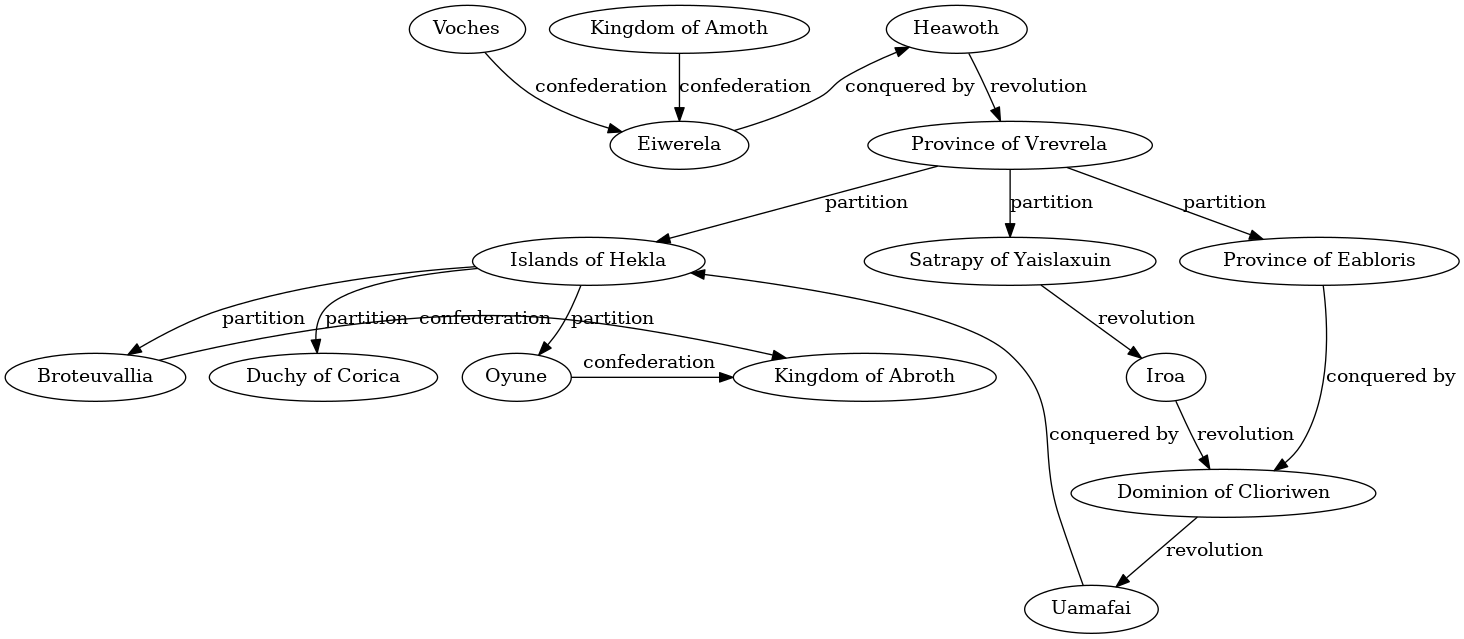

In [20]:
!python2 prochist.py --dot | dot -Tpng > historydiagram.png
from IPython.display import Image
Image(filename='historydiagram.png') 

In [15]:
!python2 prochist.py

Gather by, young ones, and let me tell you of our nations and peoples. 
 In the beginning there was "Uamafai"
These people shared a single archipelago of islands and islets in an azure sea.
Mistakes, blunders, and craven foolishness combined, and the whole edifice collapsed.
The old 'Uamafai' was no more; a new dawn broke on 'Islands of Hekla'
And then low cunning and high treachery divided them and so,
 'Islands of Hekla' dissolved in fragments, eventually becoming "Duchy of Corica" and "Dominion of Clioriwen"
Mistakes, blunders, and craven foolishness combined, and the whole edifice collapsed.
The old 'Dominion of Clioriwen' was no more; a new dawn broke on 'Kingdom of Abroth'
Years passed -  flooding ruined the crops; the famine weakened them all and so,
 'Duchy of Corica' dissolved in fragments, eventually becoming "Satrapy of Yaislaxuin" and "Eiwerela" and "Province of Eabloris"
within a generation, the hunger of the people could bear it no longer, and they rose up in violent revo